# Using EcoFOCIpy to process raw field data

## Mooring / Timeseries Data

Basic workflow for each instrument grouping is *(initial archive level)*:
- Parse data from raw files into pandas dataframe
- output initial files (pandas->csv) **ERDDAP NRT** when no meta data is added

Convert to xarray dataframe for all following work *(working or final data level):
- TODO: Add metadata from instrument yaml files and/or header info
- ingest metadata from deployment/recovery records or cast logs
- process data beyond simple file translate
- apply any calibrations or corrections
    + field corrections
    + offsets
    + instrument compensations
    + some QC were available... this would be old-school simple bounds mostly
- adjust time bounds and sample frequency (xarray dataframe)
- save as CF netcdf via xarray: so many of the steps above are optional
    + **ERDDAP NRT** if no corrections, offsets or time bounds are applied but some meta data is
    + **Working and awaiting QC** has no ERDDAP representation and is a holding spot
    + **ERDDAP Final** fully calibrated, qc'd and populated with meta information

Plot for preview and QC
- preview images (indiv and/or collectively)
- manual qc process
- automated qc process ML/AI

Further refinenments for ERDDAP hosting:


## Example below is for MTRs

Future processing of this instrument can be a simplified (no markdown) process which can be archived so that the procedure can be traced or updated

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import yaml

import EcoFOCIpy.io.mtr_parser as mtr_parser #<- instrument specific
import EcoFOCIpy.io.ncCFsave as ncCFsave
import EcoFOCIpy.metaconfig.load_config as load_config

The sample_data_dir should be included in the github package but may not be included in the pip install of the package

## Simple Processing - first step

In [23]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2019/Moorings/19aubs9/'

In [24]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = user_data_dir+'raw/mtr/5011 MTR Data.TXT'
instrument = 'MTR 5011'
mooring_meta_file = user_data_dir+'logs/19AL_AU_BS9.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/mtr_cf.yaml'
institution_meta_file = sample_data_dir+'staticdata/institutional_meta_example.yaml' #include uaf?
inst_shortname = 'mt'

#
mtr_coef = [1.188562E-03,5.309095E-04,1.288079E-06] #12-Jul-17
time_offset_seconds = 0*60 + 1
###############################################################

#init and load data
mtr_wop = mtr_parser.mtrduino()
mtr_wop_data = mtr_wop.parse(filename=datafile,datetime_index=True)
mtr_wop_data.drop(columns='',axis=1, inplace=True) 

In [25]:
mtr_wop_df = mtr_wop.adc2temp(mtr_wop_data,mtr_coef)
mtr_wop_df.index.name = 'date_time'

<Axes: xlabel='date_time'>

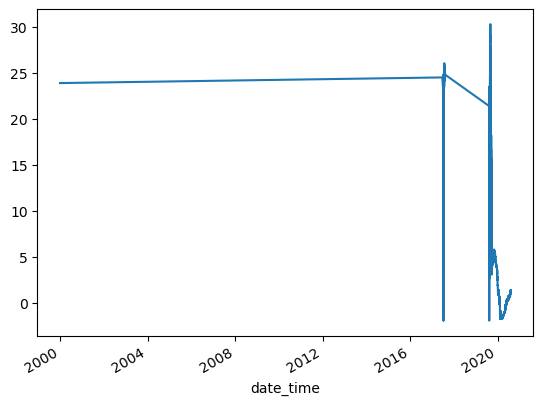

In [26]:
mtr_wop_df.s1.plot()

In [27]:
mtr_wop_df

,s1,s2,s3,s4,s5,ref
date_time,,,,,,
2000-01-01 00:01:18,23.875146,23.875146,23.875146,23.875146,23.875146,8536
2017-06-22 10:12:06,24.487978,24.487978,24.487978,24.487978,24.487978,8536
2017-07-07 10:28:27,23.192436,23.192436,23.192436,23.192436,23.192436,8537
2017-07-07 10:33:38,24.175379,24.175379,24.175379,24.175379,24.175379,8537
2017-07-07 10:34:02,24.239568,24.239568,24.239568,24.239568,24.239568,8536
...,...,...,...,...,...,...
2020-08-12 01:00:00,1.303541,1.303541,1.303541,1.303541,1.303541,8528
2020-08-12 01:10:00,1.303541,1.303541,1.303541,1.303541,1.303541,8528
2020-08-12 01:20:00,1.305065,1.305065,1.305065,1.305065,1.305065,8528


### Special note for MTR times

MTRduinos have less than 2m drift in worse case scenarios

In [28]:
mtr_wop_df, _num = mtr_wop.time_correction(mtr_wop_df, offset=time_offset_seconds) #positive to catch up with GPS time - linear correction may need to be applied... this is an offset shift at the moment 
mtr_wop_df

,s1,s2,s3,s4,s5,ref
date_time,,,,,,
2000-01-01 00:01:18.000000000,23.875146,23.875146,23.875146,23.875146,23.875146,8536
2017-06-22 10:12:06.000007281,24.487978,24.487978,24.487978,24.487978,24.487978,8536
2017-07-07 10:28:27.000014562,23.192436,23.192436,23.192436,23.192436,23.192436,8537
2017-07-07 10:33:38.000021843,24.175379,24.175379,24.175379,24.175379,24.175379,8537
2017-07-07 10:34:02.000029124,24.239568,24.239568,24.239568,24.239568,24.239568,8536
...,...,...,...,...,...,...
2020-08-12 01:00:00.999950697,1.303541,1.303541,1.303541,1.303541,1.303541,8528
2020-08-12 01:10:00.999957978,1.303541,1.303541,1.303541,1.303541,1.303541,8528
2020-08-12 01:20:00.999965259,1.305065,1.305065,1.305065,1.305065,1.305065,8528


## Time properties

Its unusual that our clocks drift to the point of concern for our instruments (if an instrument is off by 3 minutes but only sampling hourly... regridding that data will result in minimal changes).  However, there are a few time oriented modifications that may need to be made.

It is very easy to use pandas interplation and resample methods on the dataframe as is.  A few steps are suggested below:
- parse out on-deck (predeployment and recovery) data.  This can be done via pandas or xarray but requires the mooring metadata to have been read in.  See future steps below.
- even if the sample frequency is set to the desired measurement frequency, it would be good to perform a quick regridding as an assurance task
- FOCI data is usualy 1min, 10min, 1hr - and the 1min data is a fairly new (sbe56) data stream
    + subsampling high frequency data to lower frequency is easy via df.resample().mean()
    + you may want to take the median instead of the mean for noisy data (fluorometer) , occasionally decimating may be more appropriate if you want to downsize the dataset size but not smear features
    + shifting times can be a bit more involved.  There are two primary ways to do it, interpolate or shift
        - to interpolate, you will need to upsample your data to a higher frequency which will generate missing values, then interpolate (with a maximum gap size), then decimate.  This always has the artifact of smoothing data and decreasing the min/max values. **common on microcats and other 10min datasets**
        - shifting usually just involves droping extra time "digits", if you want hourly, you could just drop the trailing minutes assuming you are just off the hour (8:05 -> 8:00) or you can round to the nearest time unit but niether of these changes the data value, just the time associated with it. **common on seacats and other hourly datasets**
    + I suggest if no change is needed... resample().mean() to the sample frequency just in case there is a small deviation from expected (<1min)
    

<div class="alert alert-block alert-warning">
<b>Note:</b> take a peek at the various samples (s1-s5) and the reference resistor.  The samples should be fairly stable and the reference resistor should be somewhat stable over time (large drift may need to correct the a2d converter)
</div>

In [30]:
mtr_wop_df

,s1,s2,s3,s4,s5,ref
date_time,,,,,,
2000-01-01 00:01:18.000000000,23.875146,23.875146,23.875146,23.875146,23.875146,8536
2017-06-22 10:12:06.000007281,24.487978,24.487978,24.487978,24.487978,24.487978,8536
2017-07-07 10:28:27.000014562,23.192436,23.192436,23.192436,23.192436,23.192436,8537
2017-07-07 10:33:38.000021843,24.175379,24.175379,24.175379,24.175379,24.175379,8537
2017-07-07 10:34:02.000029124,24.239568,24.239568,24.239568,24.239568,24.239568,8536
...,...,...,...,...,...,...
2020-08-12 01:00:00.999950697,1.303541,1.303541,1.303541,1.303541,1.303541,8528
2020-08-12 01:10:00.999957978,1.303541,1.303541,1.303541,1.303541,1.303541,8528
2020-08-12 01:20:00.999965259,1.305065,1.305065,1.305065,1.305065,1.305065,8528


<Axes: xlabel='date_time'>

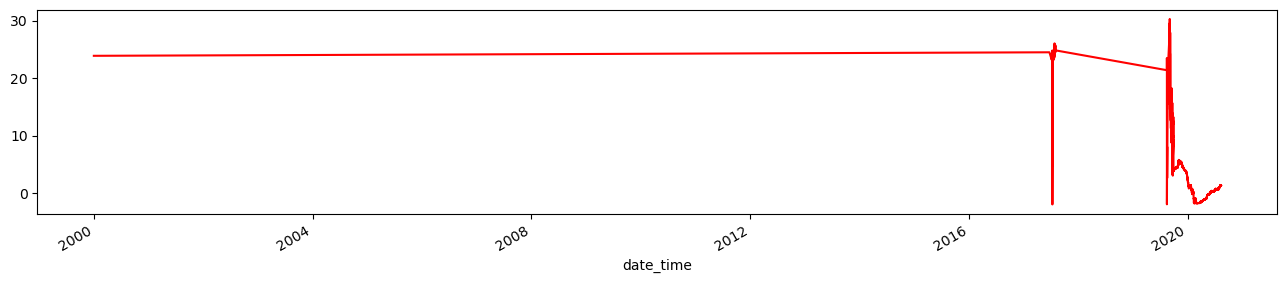

In [31]:
fig, ax = plt.subplots(1,figsize=(16, 3))
mtr_wop_df.s1.plot(ax=ax,color='r')

## Add Deployment meta information

In [32]:
#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

In [33]:
mooring_config['Instrumentation'][instrument]

{'InstType': 'MTR',
 'SerialNo': '5011',
 'DesignedDepth': 69.0,
 'ActualDepth': 69.0,
 'PreDeploymentNotes': '',
 'PostDeploymentNotes': '',
 'Deployed': 'y',
 'Recovered': 'y'}

## Add Instrument meta information

Time, depth, lat, lon should be added regardless (always our coordinates) but for a mooring site its going to be a (1,1,1,t) dataset
The variables of interest should be read from the data file and matched to a key for naming.  That key is in the inst_config file seen below and should represent common conversion names in the raw data

In [34]:
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)

In [35]:
#just a dictionary of dictionaries - simple
with open(institution_meta_file) as file:
    institution_config = yaml.full_load(file)

In [36]:
mtr_wop_df.rename(columns={'s1':'temperature'},inplace=True)

In [37]:
# Add meta data and prelim processing based on meta data
# Convert to xarray and add meta information - save as CF netcdf file
# pass -> data, instmeta, depmeta
mtr_wop_nc = ncCFsave.EcoFOCI_CFnc(df=mtr_wop_df, 
                                instrument_yaml=inst_config, 
                                operation_yaml=mooring_config, 
                                operation_type='mooring',
                                instrument_id=instrument, 
                                inst_shortname=inst_shortname)
mtr_wop_nc

At this point, you could save your file with the `.xarray2netcdf_save()` method and have a functioning dataset.... but it would be very simple with no additional qc, meta-data, or tuned parameters for optimizing software like ferret or erddap.

In [38]:
# expand the dimensions and coordinate variables
# renames them appropriatley and prepares them for meta-filled values
mtr_wop_nc.expand_dimensions()

In [39]:
mtr_wop_nc.variable_meta_data(variable_keys=list(mtr_wop_df.columns.values),drop_missing=True)
mtr_wop_nc.temporal_geospatioal_meta_data(depth='actual')
#adding dimension meta needs to come after updating the dimension values... BUG?
mtr_wop_nc.dimension_meta_data(variable_keys=['depth','latitude','longitude'])

The following steps can happen in just about any order and are all meta-data driven.  Therefore, they are not required to have a functioning dataset, but they are required to have a well described dataset

In [40]:
#add global attributes
mtr_wop_nc.deployment_meta_add()
mtr_wop_nc.get_xdf()

#add instituitonal global attributes
mtr_wop_nc.institution_meta_add(institution_yaml=institution_config)

#add instrument global attributes
mtr_wop_nc.instrument_meta_data()

#add creation date/time - provenance data
mtr_wop_nc.provinance_meta_add()

#provide intial qc status field
mtr_wop_nc.qc_status(qc_status='unknown')



## Save CF Netcdf files

Currently stick to netcdf3 classic... but migrating to netcdf4 (default) may be no problems for most modern purposes.  Its easy enough to pass the `format` kwargs through to the netcdf api of xarray.

In [41]:
# combine trim (not mandatory) and filename together (saves to test.nc without name)

depth = str(int(mooring_config['Instrumentation'][instrument]['ActualDepth'])).zfill(4)
# mooring_yaml['Instrumentation'][self.instrument_id]['DesignedDepth'])).zfill(4) #<-- alternative
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+instrument.split(' ')[-1]+'_'+depth+'m.nc'
mtr_wop_nc.xarray2netcdf_save(xdf = mtr_wop_nc.autotrim_time(),
                           filename=filename,format="NETCDF3_CLASSIC")

# don't trim the data and pass your own filename
# sbe39_wop_nc.xarray2netcdf_save(xdf = sbe39_wop_nc.get_xdf(),
#                            filename=filename,format="NETCDF4_CLASSIC")

In [42]:
mtr_wop_nc.autotrim_time()

<xarray.Dataset> Size: 731kB
Dimensions:      (time: 45681, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time         (time) datetime64[ns] 365kB 2019-09-28T20:20:00.667383741 .....
  * latitude     (latitude) float64 8B 58.96
  * longitude    (longitude) float64 8B -170.4
  * depth        (depth) float64 8B 69.0
Data variables:
    temperature  (time, depth, latitude, longitude) float64 365kB 4.082 ... 1...
Attributes: (12/33)
    Latitude_DegMMddW:                      58 57.685 N
    Longitude_DegMMddN:                     170 22.107 W
    MooringID:                              19AL_AU_BS9
    platform_deployment_date:               2019-09-28T20:18:00Z
    platform_deployment_cruise_name:        DY1908
    platform_recovery_date:                 2020-09-04T00:00:00Z
    ...                                     ...
    InstrumentSerialNumber:                 5011
    InstrumentType:                         MTR
    date_created:                           2025-08-06T13:35:45Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.\nTrimmed t...

<Figure size 640x480 with 0 Axes>

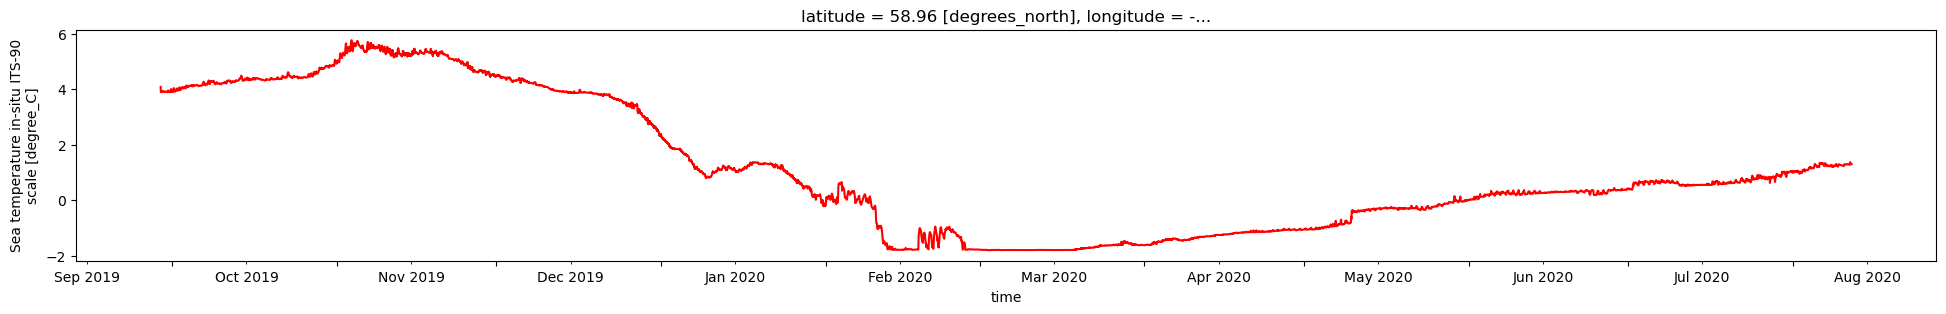

In [43]:
#wrap the plot in image settings for visual appeal
# may be able to make this cleaner or just a preset
%run '../../../settings/mpl_plot_settings.py'

%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1,figsize=(24, 3), sharex=True)
mtr_wop_nc.autotrim_time().temperature.plot(ax=ax,color='r')


# xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_formatter(DateFormatter('%b %Y'))
ax.xaxis.set_major_formatter(DateFormatter(''))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

In [44]:
#csvoutput if necessary
(mtr_wop_nc.get_xdf().to_dataframe()).to_csv(filename.replace('nc','csv'))

## QC plotting against CTDs (here or in a seperate ipynb)

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import EcoFOCIpy.io.erddap as erddap
import datetime

url = "http://ecofoci-field.pmel.noaa.gov:8080/erddap"

erddap.test_erddap_connection(url=url) #basic test for connection to internal server, no response is a good thing

In [46]:
depcast = erddap.erddapCTDretrieve(url=url,cruiseid='dy1904',qclevel='final',concastno='025')
reccast = erddap.erddapCTDretrieve(url=url,cruiseid='dy2012',qclevel='final',concastno='007')

In [47]:
depcast.columns = [x.split()[0] for x in depcast.columns]
reccast.columns = [x.split()[0] for x in reccast.columns]

some variable names switch between preliminary and final... this will eventually be resolved

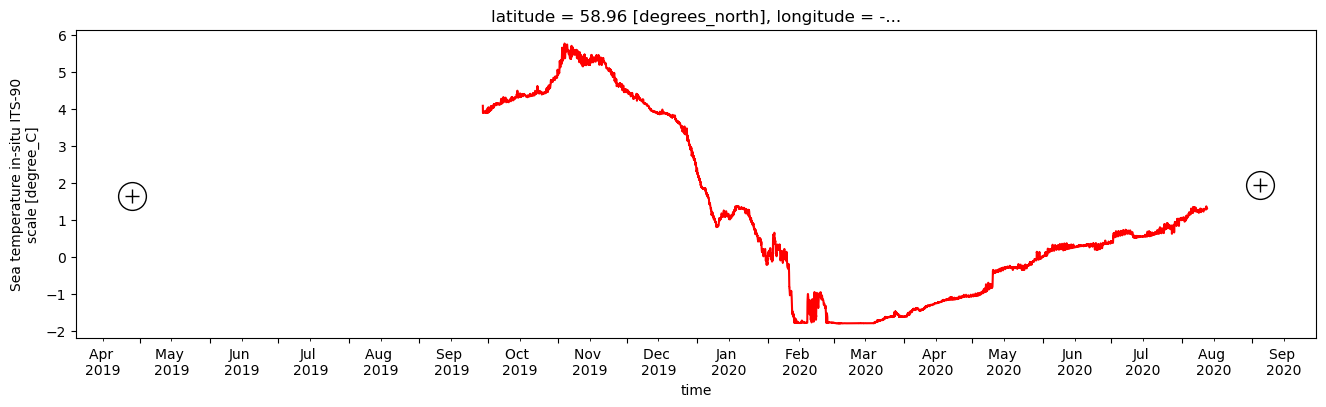

In [52]:
depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])
depth = max(depcast['pressure'])

fig, ax = plt.subplots(1,figsize=(16, 4),sharex=True)
mtr_wop_nc.autotrim_time().temperature.plot(ax=ax,color='r')
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['temperature_ch1'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='black')
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['temperature_ch1'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='black')
ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
        reccast[reccast['pressure'] == depth]['temperature_ch1'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='black')
ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
        reccast[reccast['pressure'] == depth]['temperature_ch1'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='black')


# xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_formatter(DateFormatter('%b \n%Y'))
ax.xaxis.set_major_formatter(DateFormatter(''))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

fig.savefig(f"images/{filename.replace('nc','_tempCal.png')}")

In [53]:
#print collocated cast comparison
mooring = mtr_wop_nc.autotrim_time().sel(time=datetime.datetime.strptime(depcast['time'].unique()[0],
                                                                 '%Y-%m-%dT%H:%M:%SZ'),
                                 method='nearest')
print('Deployment')
print('T0:',mooring.temperature.values[0][0],depcast[depcast['pressure'] == depth]['temperature_ch1'].values)
print('T1:',mooring.temperature.values[0][0],depcast[depcast['pressure'] == depth]['temperature_ch2'].values)

mooring = mtr_wop_nc.autotrim_time().sel(time=datetime.datetime.strptime(reccast['time'].unique()[0],
                                                                 '%Y-%m-%dT%H:%M:%SZ'),
                                 method='nearest')
print('Recovery')
print('T0:',mooring.temperature.values[0][0],reccast[reccast['pressure'] == depth]['temperature_ch1'].values)
print('T1:',mooring.temperature.values[0][0],reccast[reccast['pressure'] == depth]['temperature_ch2'].values)


Deployment
T0: [4.08236753] [1.6481]
T1: [4.08236753] [1.6483]
Recovery
T0: [1.30506489] [1.9479]
T1: [1.30506489] [1.9486]


## Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history